In [1]:
#%pip install camb

In [10]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, time, math
import torch
from tqdm import tqdm
from getdist import plots, MCSamples
#import pymultinest
import ultranest
import getdist
import IPython
#import camb

sys.path.append("/home/joeadamo/Research/Software/CLASS-PT/")
from camb import model, initialpower
from classy import Class
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'

sys.path.append('/home/joeadamo/Research') #<- parent directory of dark emulator code
from CovNet import CovNet, CovaPT

<Figure size 432x288 with 0 Axes>

In [2]:
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-HighZ-NGC/"
data_dir =  "/home/joeadamo/Research/CovNet/Data/"
PCA_dir = "/home/joeadamo/Research/CovNet/Data/PCA-Set/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [3]:
cosmo_prior = np.array([[52, 100],     #H0
                        [0.002, 0.3],  #omch2
                        #[0.005, 0.08], #ombh2
                        [0.3, 1.6],    #A / A_planck
                        #[0.9, 1.1],    #ns
                        [1, 4],        #b1
                        [0, 1],        #b2 (gaussian)
                        [0, 1],        #bGamma2 (gaussian)
                        [0, 30],       #c0 (gaussian)
                        [0, 30],       #c2 (gaussian)
                        [0, 5000]      #Pshot (gaussian)
                        ])

As_planck = 3.0448
ns_planck = 0.9649
ombh2_planck = 0.02237

# fiducial taken to be the cosmology used to generate Patchy mocks
#                     H0,   omch2,  A,  b1,     b2      bG2, c0,  c2,  Pshot
cosmo_fid = np.array([67.77,0.11827,1., 1.9485,-0.5387, 0.1, 5., -15., 100, 5e3])
cosmo_best = np.array([70.848,0.1120,0.7573, 2.8213,-0.2566, -0.0442, 12.0884, 4.54, 381.8, 984])

In [4]:
linear_settings = {'output':'mPk',
                   'non linear':'None',
                   'FFTLog mode':'FAST',
                   'cb':'Yes', # use CDM+baryon spectra
                   'Omfid':'0.31', # fiducial Omega_m
                   'YHe':0.2425,
                   #'N_ur':2.0328,
                   #'N_ncdm':1,
                   #'m_ncdm':0.06,
                   #'T_ncdm': 0.71611,
                   'tau_reio':0.052,
                    }

def calc_Om0(chain):
    Omo = (chain[:,1] + ombh2_planck + 0.00064) / (chain[:,0]/100)**2
    return Omo

def calc_sigma8_CAMB(chain):
    sigma8 = np.zeros(chain.shape[0])
    pars = camb.CAMBparams()
    k = np.linspace(0.005, 0.245, 25)
    z = 0.61
    for i in tqdm(range(chain.shape[0])):
        pars.set_cosmology(H0=chain[i,0], ombh2=ombh2_planck, omch2=chain[i,1])
        pars.InitPower.set_params(ns=ns_planck, As=np.exp(chain[i,2]*As_planck)/1e10)
        #Note non-linear corrections couples to smaller scales than you want
        pars.set_matter_power(redshifts=[z], kmax=np.amax(k))
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        # k bins will be interpolated to what we want later, so it's "ok" if this isn't exact
        kh, z1, pk = results.get_matter_power_spectrum(minkh=np.amin(k), maxkh=np.amax(k), npoints = 100)
        sigma8[i] = results.get_sigma8()
        
    return sigma8

def calc_sigma8(chain):
    cosmo = Class()
    sigma8 = np.zeros(len(chain["weight"]))
    z_pk = 0.61
    for i in tqdm(range(len(sigma8))):
        
        cosmo.set({'A_s':np.exp(chain["As"][i]*As_planck)/1e10,
                   'n_s':ns_planck,
                   'omega_b':ombh2_planck,
                   'omega_cdm':chain["omch2"][i],
                   'H0':chain["H0"][i],
                   'z_pk':z_pk
                  })
        #Set additional CLASS-PT settings
        cosmo.set(linear_settings)
        
        sigma8[i] = cosmo.sigma8()
        cosmo.struct_cleanup()
    return sigma8

# Omo_fid = calc_Omo(np.vstack([cosmo_fid, cosmo_fid]))
# sigma8_fid = calc_sigma8(np.vstack([cosmo_fid, cosmo_fid]))
# print(Omo_fid[0,-1], sigma8_fid[0,-1])

In [5]:
def plot_cosmo_contours(sample_list, param_labels, legend_labels, colors, num_plots, fill=True, truth=[]):
    
    truth_dict = {}
    all_names = ["omch2", "h", "As", "b1", "b2", "bG2", "cs0", "cs2", "cbar", "Pshot"]
    
    if len(truth) != 0:
        for name, truth_val in zip(param_labels, truth):
            truth_dict[name] = truth_val
    
    #KDE_settings={'mult_bias_correction_order':2, "boundary_correction_order":2}
    
    labels = param_labels[:num_plots]
    getdist_samples = []
    # loop thru each chain
    for i in range(len(legend_labels)):
        if "weight" in sample_list[i].dtype.names:
            weights = sample_list[i]["weight"].flatten()
            samples = np.zeros((len(weights), num_plots))
            for j in range(num_plots):
                samples[:, j] = np.array(sample_list[i][sample_list[i].dtype.names[j+2]])
            getdist_samples.append(MCSamples(samples=samples, weights=weights, names = labels, labels=labels, settings=KDE_settings, sampler='nested'))
        else:
            samples = np.zeros((len(sample_list[i]["h"]), num_plots))
            for j in range(num_plots):
                samples[:, j] = np.array(sample_list[i][all_names[j]])
            getdist_samples.append(MCSamples(samples=samples, loglikes=sample_list[i]["loglike"], names = labels, labels=labels))
            
    g = plots.get_subplot_plotter()
    g.settings.legend_fontsize = 16
    if len(truth)!=0: g.triangle_plot(getdist_samples, filled=fill, legend_labels=legend_labels,
                                      markers=truth_dict, contour_colors=colors)
    else:             g.triangle_plot(getdist_samples, filled=fill, legend_labels=legend_labels,
                                      contour_colors=colors)
    
    return g
    
def plot_derived_contours(sample_list, legend_labels, colors, fill=True, mark_truth=False):
    labels =  ["\Omega_m", "H_0", "\sigma_8", "\omega_{cdm}"]
        
    cosmo_truth = [0.286, 69.21, 0.7365, 0.1149978]
    truth_dict = {}
    for name, truth in zip(labels, cosmo_truth):
        truth_dict[name] = truth

    getdist_samples = []
    for i in range(len(legend_labels)):

        if "weight" in sample_list[i].dtype.names:
            samples = np.vstack([sample_list[i]["Omega_0"], sample_list[i]["H0"], sample_list[i]["sigma8"], sample_list[i]["omch2"]]).T
            weights = sample_list[i]["weight"].flatten()
            getdist_samples.append(MCSamples(samples=samples, weights=weights, names = labels, labels=labels, sampler='nested'))
        else:
            samples = np.vstack([sample_list[i]["Omega_m"], sample_list[i]["H0"], sample_list[i]["sigma8"], sample_list[i]["omch2"]]).T
            getdist_samples.append(MCSamples(samples=samples, loglikes=sample_list[i]["loglike"], names = labels, labels=labels))
            
    g = plots.get_subplot_plotter()
    if mark_truth==True: g.triangle_plot(getdist_samples, filled=fill, contour_colors=colors, legend_labels=legend_labels, markers=truth_dict)
    else:                g.triangle_plot(getdist_samples, filled=fill, contour_colors=colors, legend_labels=legend_labels)
    
    return g

## MontePython Code

In [6]:
# load in / visualize parameter covariance matrix for testing
montepython_dir = "/home/joeadamo/Research/CovNet/chains/MontePython/"
def load_chains(prefix, burn_in, names):
    
    all_filenames = next(os.walk(montepython_dir+prefix), (None, None, []))[2]  # [] if no file
    chain_files = []
    for i in range(len(all_filenames)):
        if ".txt" in all_filenames[i]:
            chain_files.append(all_filenames[i])
            
    chain_1 = np.genfromtxt(montepython_dir+prefix+chain_files[0], names=names)
    chain_gaussian = np.genfromtxt(montepython_dir+prefix+chain_files[1], names=names)
    chain_no_det = np.genfromtxt(montepython_dir+prefix+chain_files[2], names=names)
    chain_4 = np.genfromtxt(montepython_dir+prefix+chain_files[3], names=names)

    # remove burn-in and "non-markovian" points from each chain
    chain_1 = chain_1[burn_in[0]:]
    chain_gaussian = chain_gaussian[burn_in[1]:]
    chain_no_det = chain_no_det[burn_in[2]:]
    chain_4 = chain_4[burn_in[3]:]

    # combine all chains into one big chain
    chain_combined = np.concatenate((chain_1, chain_gaussian, chain_no_det, chain_4))
    return chain_combined

def load_multinest_chains(prefix, burn_in, names):
    chain = np.genfromtxt(montepython_dir+prefix, names=names)
    chain = chain[burn_in:]
    return chain

In [7]:
#prefix="/test-marg/2023-01-27_15000"
#prefix="test-2/2023-02-02_15000"
prefix_1 = "simulated-data/fixed-gaussian/"
prefix_2 = "simulated-data/vary-gaussian/"
prefix_3 = "simulated-data/vary-no-determinant-1/"
prefix_4 = "simulated-data/test-emulator-MLP/"
prefix_5 = "simulated-data/test-emulator-AE/"
prefix_6 = "simulated-data/test-emulator-VAE/"
prefix_7 = "simulated-data/gaussian-emulator-MLP/"
prefix_8 = "simulated-data/gaussian-emulator-AE/"
prefix_9 = "simulated-data/gaussian-emulator-VAE/"

names=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "cs0", "cs2", "Pshot", "b4", "Omega_m", "H0", "sigma8"]
names_MS=["?", "-ln(Z)", "omch2", "h", "As", "b1", "b2", "bG2", "cs0", "cs2", "Pshot", "b4", "Omega_m", "H0", "sigma8"]
names_marg=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "Omega_m", "H0", "sigma8"]

# To find out how many points to remove right now, run ./montpython.py info
burn_in_1 = [14, 13, 10, 11]
burn_in_2 = [167, 192, 177, 157]
burn_in_3 = [91, 109, 89, 106]
burn_in_4 = [20, 14, 18, 15]
burn_in_5 = [123, 126, 108, 139]
burn_in_6 = [124, 126, 109, 106]
burn_in_7 = [123, 117, 113, 141]
burn_in_8 = [305, 306, 291, 292]
burn_in_9 = [27, 56, 23, 29]

chain_fixed = load_chains(prefix_1, burn_in_1, names_marg)
chain_gaussian = load_chains(prefix_2, burn_in_2, names_marg)
chain_no_det = load_chains(prefix_3, burn_in_3, names_marg)
chain_MLP = load_chains(prefix_4, burn_in_4, names_marg)
chain_AE = load_chains(prefix_5, burn_in_5, names_marg)
chain_VAE = load_chains(prefix_6, burn_in_6, names_marg)
chain_gaussian_MLP = load_chains(prefix_7, burn_in_7, names_marg)
chain_gaussian_AE = load_chains(prefix_8, burn_in_8, names_marg)
chain_gaussian_VAE = load_chains(prefix_9, burn_in_9, names_marg)

In [8]:
# test that each chain looks good
# for name in chain_4.dtype.names:
#     plt.figure()
#     plt.plot(range(chain_4.shape[0]), chain_4[name])
#     plt.xlabel("N")
#     plt.ylabel(name)

Removed no burn in


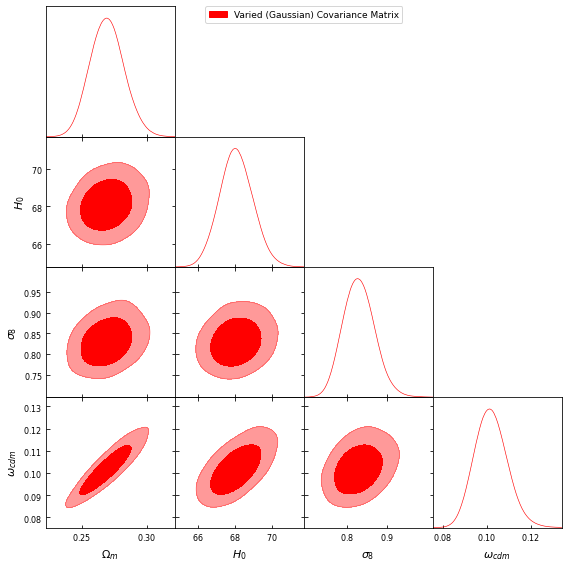

In [11]:
#print(getdist.plots.GetDistPlotSettings())
axes = plot_derived_contours([chain_gaussian], ["Varied (Gaussian) Covariance Matrix"],  ["red"], True)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


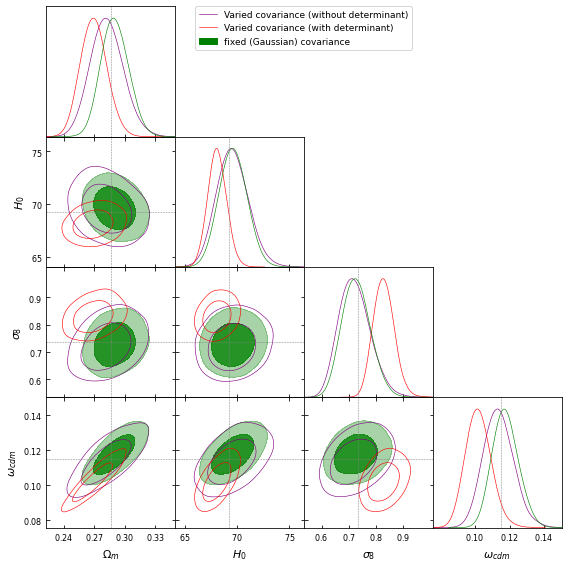

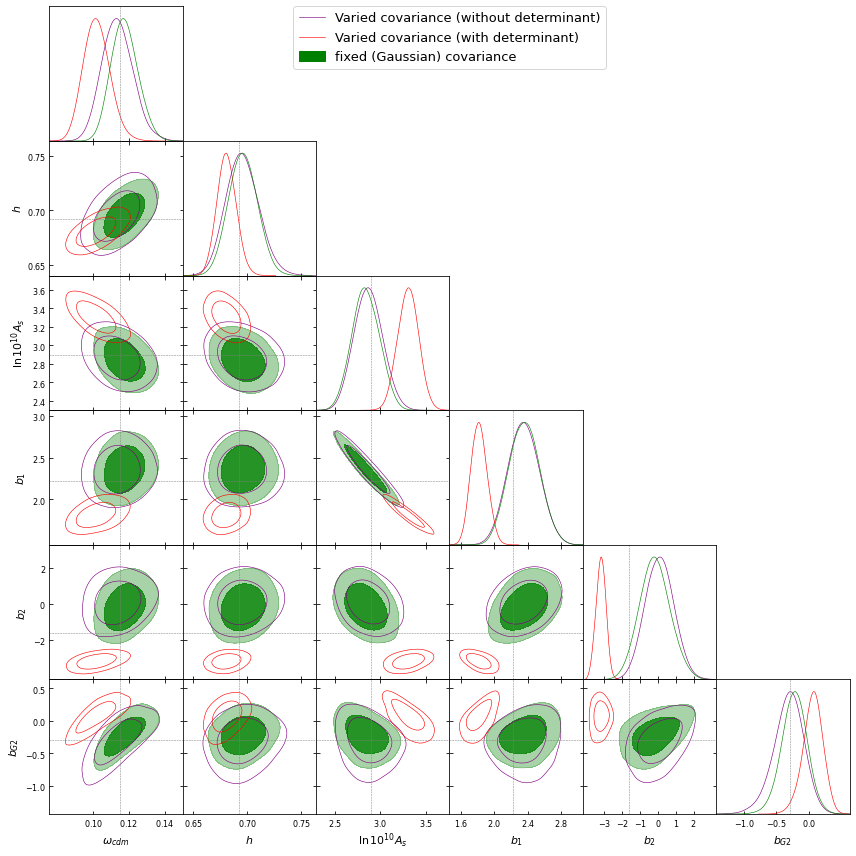

In [12]:
#plot_derived_contours([chain_1, chain_no_det], ["with marginalization (MH)", "without marginalization (Multinest)"], True)
#plot_derived_contours([chain_no_det, chain_1], ["Beutler Data Vector (Misha's Lilelihood)", "Wadekar Data Vector"], True)
#plot_derived_contours([chain_no_det, chain_gaussian], ["Beutler Data Vector (Misha's likelihood)", "Beutler Data Vector (old marginalized likelihood)"], True)
labels =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]
truth = np.array([0.1149978, 0.6920868, 2.894525, 2.226, -1.605, -0.297, 0, 0, 5000, 0])

axs = plot_derived_contours([chain_no_det, chain_gaussian, chain_fixed], 
                      ["Varied covariance (without determinant)", "Varied covariance (with determinant)", "fixed (Gaussian) covariance"], 
                      ["purple", "red", "green"], [False, False, True], True)

axs = plot_cosmo_contours([chain_no_det, chain_gaussian, chain_fixed], labels,
                      ["Varied covariance (without determinant)", "Varied covariance (with determinant)", "fixed (Gaussian) covariance"],
                      ["purple", "red", "green"], 6, truth=truth, fill=[False, False, True])

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


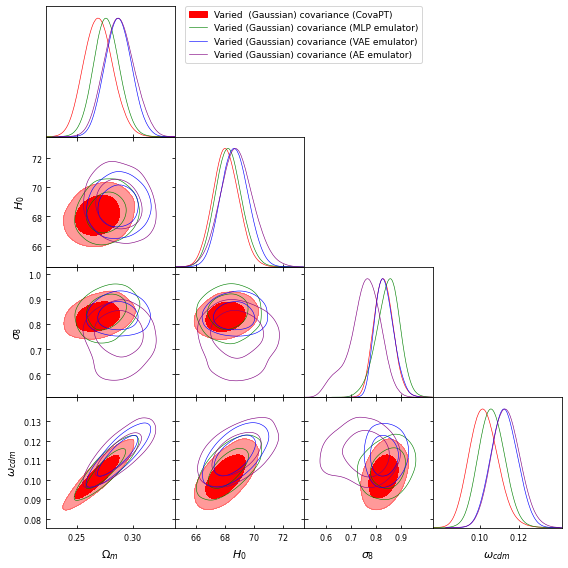

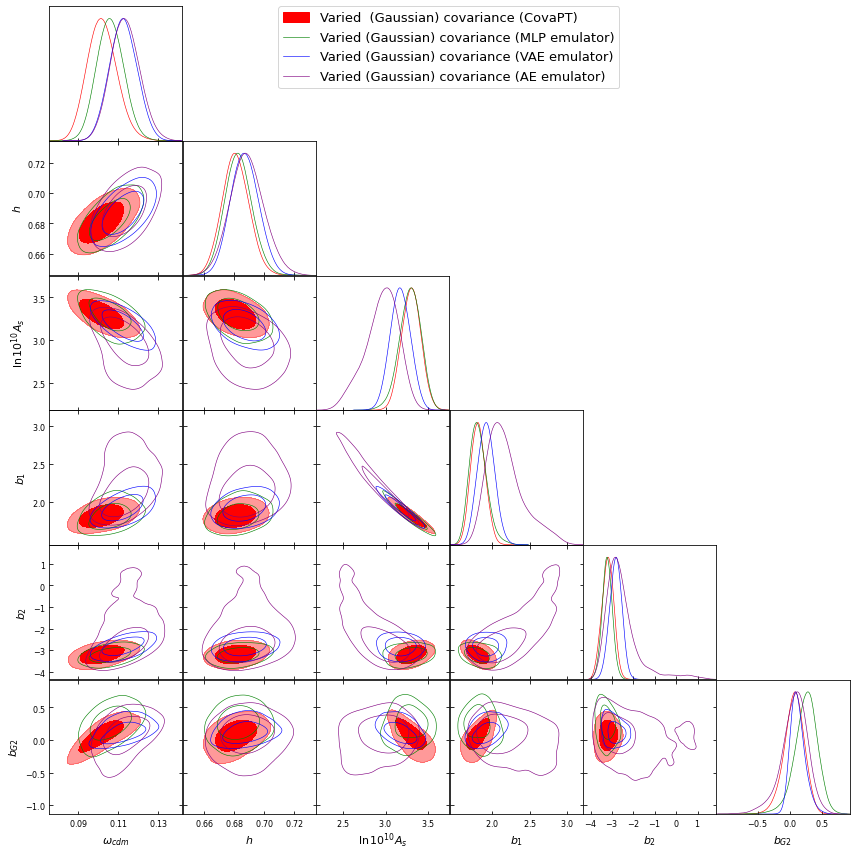

In [14]:
#plot_cosmo_contours([chain_gaussian, chain_1], labels, ["Beutler Data Vector", "Montepython Data Vector"],6, truth=[], fill=True)
#plot_cosmo_contours([chain_no_det, chain_1], labels, ["Beutler Data Vector (Misha's Likelihood)", "Wadekar Data Vector"], 6, truth=[], fill=True)
#plot_cosmo_contours([chain_no_det, chain_gaussian], labels, ["Beutler Data Vector (Misha's likelihood)", "Beutler Data Vector (old marginalized likelihood)"], 6, truth=[], fill=True)

axs = plot_derived_contours([chain_gaussian, chain_gaussian_MLP, chain_gaussian_VAE, chain_gaussian_AE],
                      ["Varied  (Gaussian) covariance (CovaPT)", "Varied (Gaussian) covariance (MLP emulator)", "Varied (Gaussian) covariance (VAE emulator)", "Varied (Gaussian) covariance (AE emulator)"], 
                      ["red", "green", "blue", "purple"], [True, False, False, False], False)

axs = plot_cosmo_contours([chain_gaussian, chain_gaussian_MLP, chain_gaussian_VAE, chain_gaussian_AE], labels,
                      ["Varied  (Gaussian) covariance (CovaPT)", "Varied (Gaussian) covariance (MLP emulator)", "Varied (Gaussian) covariance (VAE emulator)", "Varied (Gaussian) covariance (AE emulator)"], 
                      ["red", "green", "blue", "purple"], 6, truth=[], fill=[True, False, False, False])

In [13]:
# save the varied gaussian covariance term multiplied by a "Temperature" of 1.2 to be used in the
# performace sampling test

V1 = 1; V2 = 1
for i in range(2, len(chain_gaussian.dtype.names)-3):
    name_2 = chain_gaussian.dtype.names[i]
    name_3 = chain_no_det.dtype.names[i]
    V1*= (np.amax(chain_gaussian[name_2]) - np.amin(chain_gaussian[name_2]))
    V2*= (np.amax(chain_no_det[name_3]) - np.amin(chain_no_det[name_3]))

print("V1 = {:0.3f}, V2 = {:0.3f}, ratio = {:0.4f}".format(V1, V2, V1/V2))
    
chain_importance = np.zeros((len(chain_no_det.dtype.names)-2, chain_no_det.shape[0]))

for i in range(2, len(chain_no_det.dtype.names)):
    idx = i-2
    name = chain_no_det.dtype.names[i]
    # apply the tempterature
    chain_importance[idx, :] = 1.21 * (chain_no_det[name] - np.mean(chain_no_det[name])) + np.mean(chain_no_det[name])

    # plt.figure()
    # plt.plot(range(chain_importance.shape[1]), chain_importance[idx,:], alpha=0.5, label="temp applied")
    # plt.plot(range(chain_no_det.shape[0]), chain_no_det[name], alpha=0.5, label="no temp applied")
    # plt.xlabel("N")
    # plt.ylabel(name)
    # plt.legend()

V1 = 0.007, V2 = 0.231, ratio = 0.0284


In [16]:
header_str = "H0\t omch2\t A\t b1\t b2\t bG2"
save_data = np.vstack((chain_importance[1,:]*100., chain_importance[0,:], chain_importance[2,:] / 3.0447, chain_importance[3,:], chain_importance[4,:], chain_importance[5,:])).T
print(save_data.shape)
#np.savetxt(data_dir+"inportance-params.txt", save_data, header=header_str)

NameError: name 'chain_importance' is not defined

In [17]:
load_data = np.loadtxt(data_dir+"inportance-params.txt", skiprows=1)[:15000]
print(load_data.shape)

print(load_data[:,0])

(15000, 6)
[66.51643921 70.10244361 69.85994751 ... 69.95579161 70.11226881
 72.04624811]


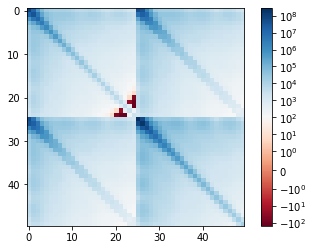

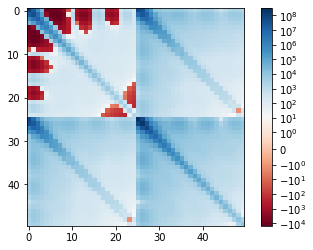

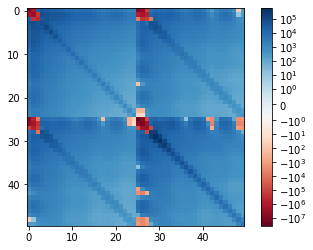

In [18]:
# builds an "MCMC" chain based on the above sampled parameters and non-gaussian covariance matrices 
# that I calculated from them

dx=np.loadtxt("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/ngc_z3/pk_ngc_z3_sim.dat", skiprows = 0)
inportance_dir = "/home/joeadamo/Research/CovNet/Data/Inportance-Set/"

k1 = dx[:,0][:25]
Pk0 = dx[:,1][:25]
Pk2 = dx[:,2][:25]
data_vector = np.hstack([Pk0, Pk2])

chain_NG = np.zeros((load_data.shape[0], 9))
Mat_Calc = CovaPT.Analytic_Covmat(0.61)

data = np.load(inportance_dir+"CovA-09000.npz")
C1 = data["C_G"] + data["C_SSC"] + data["C_T0"]
data = np.load(inportance_dir+"CovA-07000.npz")
C2 = data["C_G"] + data["C_SSC"] + data["C_T0"]

plt.figure()
plt.imshow(C1, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C1), vmax=np.amax(C1)))
cbar = plt.colorbar()

plt.figure()
plt.imshow(C2, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C2), vmax=np.amax(C2)))
cbar = plt.colorbar()

plt.figure()
plt.imshow(C1 - C2, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C1-C2), vmax=np.amax(C1-C2)))
cbar = plt.colorbar()

# for i in tqdm(range(load_data.shape[0])):
#     data = np.load(inportance_dir+"CovA-"+f'{i:05d}'+".npz")
#     C = data["C_G"] + data["C_SSC"] + data["C_T0"]
    
#     params = np.concatenate((data["params"], [0, 0, 500, 0]))
#     C_marg, model_vector, om0, s8 = Mat_Calc.get_marginalized_covariance(params, C)
#     inv_C_marg = np.linalg.inv(C_marg)
    
#     b1, b2, bG2 = params[3], params[4], params[5]
#     x = data_vector - model_vector
#     chi2 = np.inner(x,np.inner(inv_C_marg,x))
#     chi2 = chi2 + (b2 - 0.)**2./1**2. + (bG2 - 0.)**2/1**2.

#     lkl = chi2 + np.linalg.slogdet(C_marg)[1] - np.linalg.slogdet(C)[1]
#     chain_NG[i] = np.hstack([lkl, data["params"], om0, s8])
    
# print(chain_NG[0])

In [19]:
#header_str = "lkl\t H0\t omch2\t A\t b1\t b2\t bG2\t Omega_m\t sigma8"
#np.savetxt(data_dir+"chain_inportance.txt", chain_NG, header=header_str)

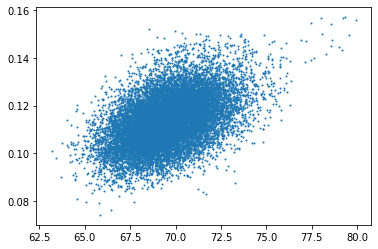

In [20]:
names=["loglike", "H0", "omch2", "As", "b1", "b2", "bG2", "Omega_m", "sigma8"]
chain_load = np.genfromtxt(data_dir+"chain_inportance.txt", names=names)
chain_load["As"] *= 3.0447

new_dt = np.dtype(chain_load.dtype.descr + [('h', "<f8")])
chain_NG = np.zeros(chain_load.shape, dtype=new_dt)
for name in chain_load.dtype.names:
    chain_NG[name] = chain_load[name]
chain_NG["h"] = chain_NG["H0"] / 100.
    

plt.scatter(chain_NG["H0"], chain_NG["omch2"], s=1)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


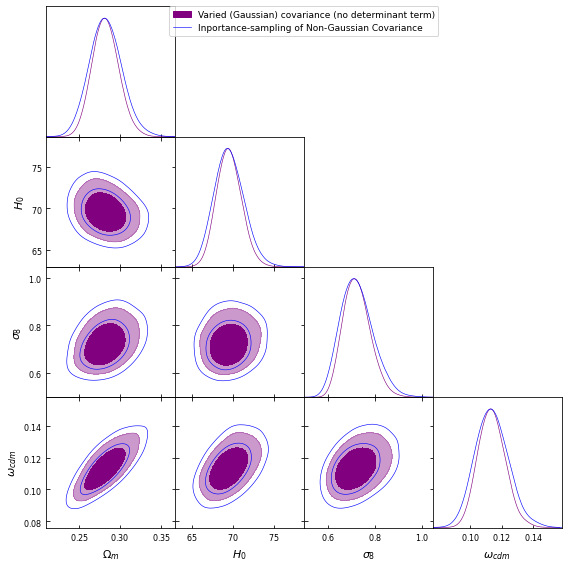

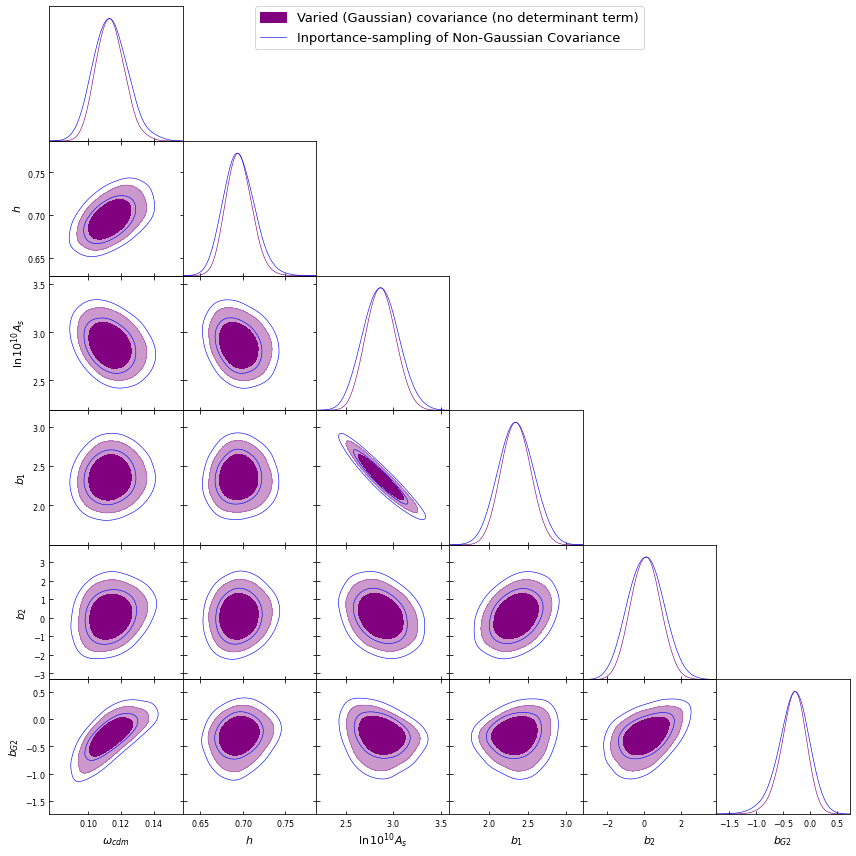

In [21]:
g = plot_derived_contours([chain_no_det, chain_NG], 
                      ["Varied (Gaussian) covariance (no determinant term)", "Inportance-sampling of Non-Gaussian Covariance"], 
                      ["purple", "blue"], [True, False], False)

axs = plot_cosmo_contours([chain_no_det, chain_NG], labels,
                      ["Varied (Gaussian) covariance (no determinant term)", "Inportance-sampling of Non-Gaussian Covariance"],
                      ["purple", "blue"], 6, truth=[], fill=[True, False])

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


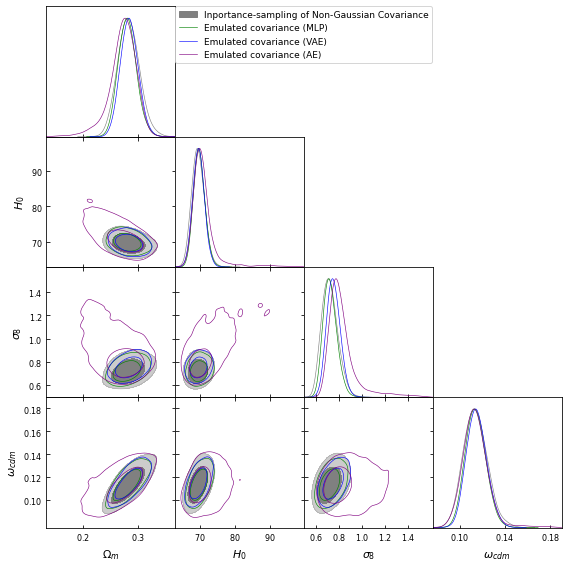

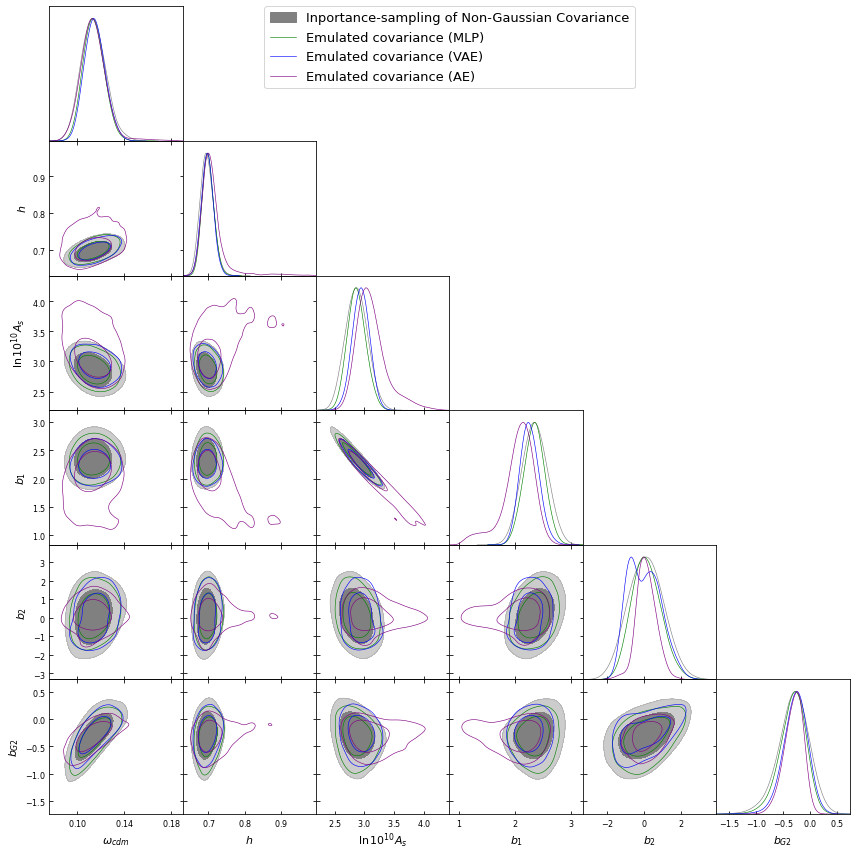

In [22]:
g = plot_derived_contours([chain_NG, chain_MLP, chain_VAE, chain_AE], 
                      ["Inportance-sampling of Non-Gaussian Covariance", "Emulated covariance (MLP)", "Emulated covariance (VAE)", "Emulated covariance (AE)"],
                      ["grey", "green", "blue", "purple"], [True, False, False, False], False)

axs = plot_cosmo_contours([chain_NG, chain_MLP, chain_VAE, chain_AE], labels,
                      ["Inportance-sampling of Non-Gaussian Covariance", "Emulated covariance (MLP)", "Emulated covariance (VAE)", "Emulated covariance (AE)"],
                      ["grey", "green", "blue", "purple"], 6, truth=[], fill=[True, False, False, False])

In [57]:
# H0_test = np.zeros(15000)
# omch2_test = np.zeros(15000)

for i in tqdm(range(load_data.shape[0])):
    data = np.load(inportance_dir+"CovA-"+f'{i:05d}'+".npz")
    C = data["C_G"] + data["C_SSC"] + data["C_T0"]
    
    H0_test[i] = data["params"][0]
    omch2_test[i] = data["params"][1]

print(H0_test)
plt.scatter(H0_test, omch2_test, s=1)
#plt.scatter(load_data[:,0], load_data[:,1], s=1)

  0%|                                                 | 0/15000 [00:00<?, ?it/s]


NameError: name 'H0_test' is not defined

In [ ]:
Mat_Calc = CovaPT.Analytic_Covmat(0.61)
C_G, C_SSC, C_T0 = Mat_Calc.get_full_covariance(params_test)
C_fid = C_G + C_SSC + C_T0
#C_fid = C_G

t2 = time.time()
print("Matrix generated in {:0.2f} s".format(t2 - t1))

print(C_fid.shape)

print("cond(C) = {:0.3e}".format(np.linalg.cond(C_fid)))
try:
    L = np.linalg.cholesky(C_fid)
    print("Covariance matrix is positive-definite :)")
except np.linalg.LinAlgError as err:
    print("Covariance matrix is NOT positive-definite!")
    
try:
    L = np.linalg.cholesky(C_G)
    print("Gaussian term is positive-definite :)")
except np.linalg.LinAlgError as err:
    print("Gaussian term is NOT positive-definite!")

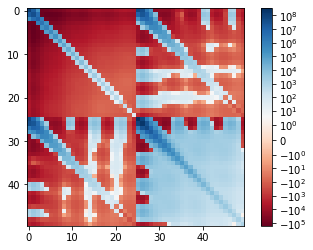

In [40]:
plt.figure()
plt.imshow(C_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
plt.colorbar()

4191.924735522535 2748.4879135930723


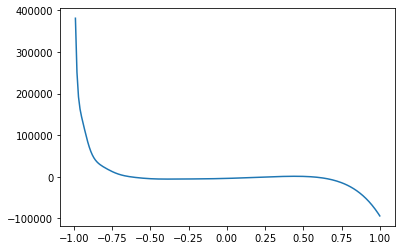

In [55]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad
import scipy
b1 = params_test[3]
Omega_m = (params_test[1] + 0.02237 + 0.00064) / (params_test[0]/100)**2

def Dz(z,Om0):
    return(scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3)
                                /scipy.special.hyp2f1(1/3., 1, 11/6., 1-1/Om0)/(1+z))

pdata = Mat_Calc.Pk_lin_CLASS(params_test[0], params_test[1], 0.02237, params_test[2]*3.0447, 0.9649)

Plin=InterpolatedUnivariateSpline(pdata[:,0], Dz(0.61, Omega_m)**2*b1**2*pdata[:,1])

k1 = 0.195; k2 = 0.195
#k1 = 0.20500000000000002; k2= 0.20500000000000002
k1 = 0.185; k2 = 0.185
u = np.linspace(-1, 1, 200)
integrand = Mat_Calc.trispIntegrand(u, k1,k2,Plin)
temp = quad(Mat_Calc.trispIntegrand, -1, 1,args=(k1,k2,Plin), limit=200)[0]/2.

du = u[2] - u[1]
temp2 = np.sum(integrand[1:] * du) / 2.
print(temp, temp2)

plt.plot(u, integrand)

In [228]:
from astropy.modeling import models, fitting

det_file = np.load("/home/joeadamo/Research/CovNet/Data/determinants.npz")

det_params = det_file["params"]
#det_term = det_file["det_marg"]
det_term = det_file["det_gaussian"]

det_params = det_params[~np.isnan(det_term)]
det_term = det_term[~np.isnan(det_term)]

temp = det_params[:,1].copy()
det_params[:,1] = det_params[:,0].copy()
det_params[:,0] = temp
#det_params[:,2] = det_params[:,2] * 3.0347

def make_contours(x, y, z, bins, bins_new, values):
    
    # first average out the determinant over some bin resolution to make a regular grid of data points
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    y_grid, x_grid = np.mgrid[:bins, :bins]
    y_fit, x_fit = np.mgrid[:bins_new, :bins_new] *bins / bins_new
    
    p_init = models.Polynomial2D(degree=4)
    fit_p = fitting.LevMarLSQFitter()
    poly_fit = fit_p(p_init, x_grid, y_grid, z_new)
    z_fit = poly_fit(x_fit, y_fit)
    
    x_new = np.linspace(np.amin(x), np.amax(x), bins_new)
    y_new = np.linspace(np.amin(y), np.amax(y), bins_new)
    
    curves_x, curves_y = [],[]
    for i in range(len(values)):
        z = z_fit - values[i]
        curve_x = []; curve_y = []
        curve_sort = []
        for i in range(bins_new):
            for j in range(bins_new):
                if abs(z[-j,i]) < 1e-1:
                    curve_x.append(x_new[i])
                    curve_y.append(y_new[j])
                    curve_sort.append(np.sqrt(1.*i**2 + 1.*j**2))
        sort_idx = np.array(curve_sort).argsort()
        curve_x = np.array(curve_x)[sort_idx]
        curve_y = np.array(curve_y)[sort_idx]

        curves_x.append(curve_x)
        curves_y.append(curve_y)
    return x_new, y_new, curves_x, curves_y, z_fit

def make_diagonal(x, y, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

In [229]:
# labels =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]
# g = plot_cosmo_contours([chain_no_det, chain_gaussian], labels,
#                       ["Varied covariance (without determinant)", "Varied covariance (with determinant)"],
#                       ["purple", "red"], 6, truth=truth, fill=[False, False])

450.8309626455644 1204.4540400415688
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:xlabel='$h$'>]


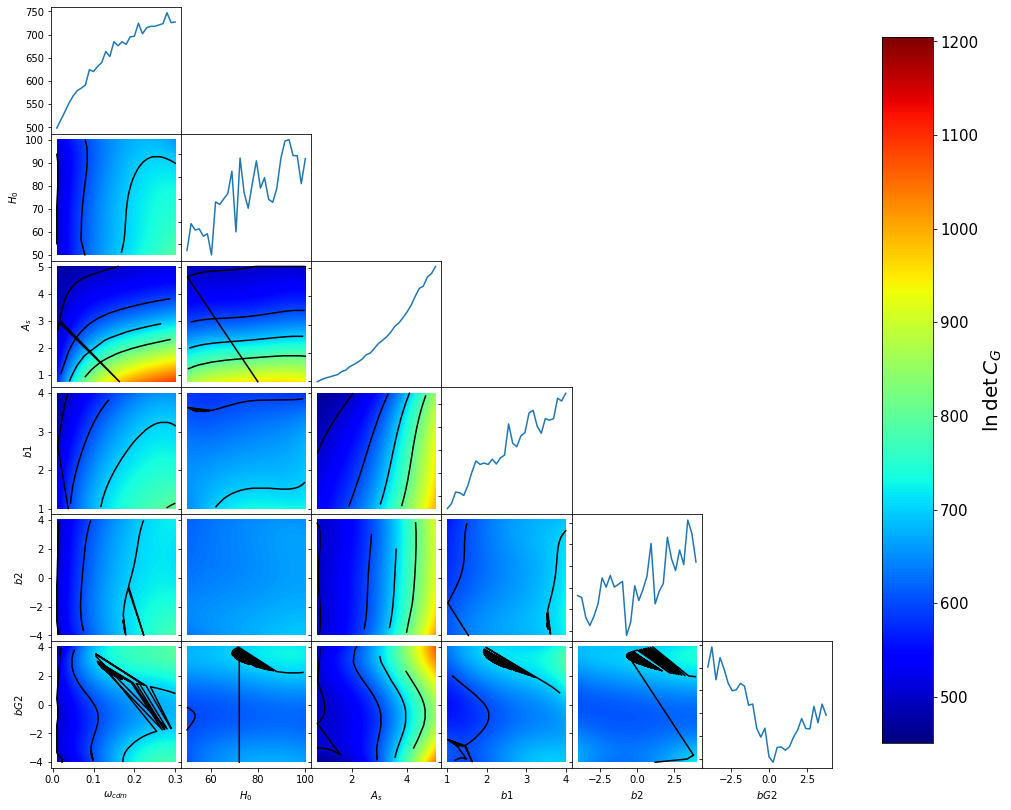

In [231]:
label=r"$\ln{\det{C_G}}$"
names = ['omch2', 'h', "As", "b1", "b2", "bG2", "chi_squared"]
labels= [r'$\omega_{cdm}$', r"$H_0$", r"$A_s$", "$b1$", "$b2$", "$bG2$", label]
cmap="jet"
print(np.amin(det_term), np.amax(det_term))
extents=[np.amin(det_term), np.amax(det_term)]

print(g.subplots[1:,1])
# for i in range(6):
#     for j in range(6):
#         ax = g.subplots[i, j]
        
# for ax in g.subplots[2:,1]:
#     try:
#         ax.axvline(0.7, color='gray', ls='--')
#         print("hi!")
#     except: continue
    
fig, axs = plt.subplots(6,6, figsize=(14,14))
for i in range(6):
    for j in range(6):
        if i < j:
            axs[i][j].axis("off")
            continue
        if i == j:
            x, y = make_diagonal(det_params[:,j], det_term, 30)
            #axs[i][j].axhline(0, color="red")
            axs[i][j].plot(x, y)
            #axs[i][j].set_yscale("log")
        else:
            X, Y, c_x, c_y, Z = make_contours(det_params[:,j], det_params[:,i], det_term, 30, 250, [500, 600, 700, 800])
            axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
            for a in range(4):
                axs[i,j].plot(c_x[a], c_y[a], c="black")
            axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
            axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
            # if log_scale == True: img = axs[i][j].scatter(params[:,j], params[:,i], c=data, s=1, alpha=0.8, cmap=cmap,
            #                                               norm=colors.SymLogNorm(vmin=extents[0], vmax=extents[1], linthresh=1))
            # else: img = axs[i][j].scatter(params[:,j], params[:,i], c=data, s=1, vmin=extents[0], vmax=extents[1], alpha=0.8, cmap=cmap)
        #if i != j: axs[i][j].axhline(params_fid[i], linestyle="--", c="black")
        #axs[i][j].axvline(params_fid[j], linestyle="--", c="black")
        if i == 5: axs[i][j].set_xlabel(labels[j])
        if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
        if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
        elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
        elif j != 0 and i != 5:
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label(labels[-1] ,size=20)
cbar.ax.tick_params(labelsize=15) 
plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout(

#IPython.display.display(g.fig)

(10, 10)
3.98e-05
2.12e-04
1.54e-02
2.32e-02
3.52e-01
3.09e-02
2.08e+00
1.67e+00
9.15e-01
2.58e-03


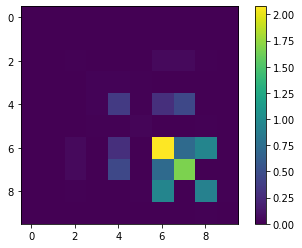

In [50]:
#chain_sub = np.vstack([chain_no_det["H0"], chain_no_det["omch2"], chain_no_det["Omega_m"], chain_no_det["sigma8"]]).T
chain_sub = np.vstack([chain_5["omch2"], chain_5["h"], chain_5["As"], chain_5["b1"], \
                       chain_5["b2"], chain_5["bG2"], chain_5["cs0"], chain_5["cs2"], \
                       chain_5["Pshot"], chain_5["b4"]]).T
C_theta = np.cov(chain_sub, rowvar=False)

print(C_theta.shape)
for i in range(C_theta.shape[0]):
    print("{:0.2e}".format((C_theta[i,i])))

header = "omega_cdm, h, ln10^{10}A_s, b^{(1)}_1, b^{(1)}_2, b^{(1)}_{G_2},c^{(1)}_{0}, c^{(1)}_{2}, P^{(1)}_{shot}, b^{(1)}_4"#\Omega_m, sigma8"
    
np.savetxt(montepython_dir+"simulated-data/ms.covmat", C_theta, header=header)
L = np.linalg.cholesky(C_theta)

plt.imshow(C_theta, vmin=0)
plt.colorbar()

#### code to recalculate the covariance matrix

In [41]:
# This cell computes the covariance matrix at some input cosmology
# t1 = time.time()
# params_fid = np.array([67.77,0.1184,1, 1.9485,-0.5387, 0.1, 5, -15, 100., 5e3])
# params_best = np.array([70.848,0.1120,0.7573, 2.8213,-0.2566, -0.0442, 12.0884, 4.54, 381.8, 984])
# params_marg =  np.array([67.77,0.1184,1, 1.9485,-0.5387, 0.1, 0, 0, 500., 0])
# params_marg_best =  np.array([70.725, 0.11182, 0.7243, 3.3323, -0.39812, -0.010124, 0, 0, 500., 0])
# params_far = np.array([85, 0.21182, 1.2243, 0.3323, -0.39812, -0.010124, 0, 0, 500., 0])
# C_G = CovaPT.get_gaussian_covariance(params_marg_best)
# C_SSC, C_T0 = CovaPT.get_non_gaussian_covariance(params_marg_best)
# C_fid = C_G + C_SSC + C_T0
# #C_fid = C_G
# t2 = time.time()
# print("Matrix generated in {:0.2f} s".format(t2 - t1))

# print(C_fid.shape)

# try:
#     L = np.linalg.cholesky(C_fid)
#     print("Covariance matrix is positive-definite :)")
# except np.linalg.LinAlgError as err:
#     print("Covariance matrix is NOT positive-definite!")
    
# np.savez("../Data/Cov_Marg_Best.npz", C_G=C_G, C_SSC=C_SSC, C_T0=C_T0)


AttributeError: module 'CovNet.CovaPT' has no attribute 'get_gaussian_covariance'

In [42]:
# plt.figure()
# plt.imshow(C_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
# plt.colorbar()

NameError: name 'C_fid' is not defined

<Figure size 432x288 with 0 Axes>

## Ultranest Code

In [7]:
fiducial_dir = "/home/joeadamo/Research/CovNet/chains/Ultranest/Simulated-Likelihood/full-model/"
#fiducial_dir = "/home/joeadamo/Research/CovNet/chains/Ultranest/HighZ-NGC/fixed-fiducial/"
best_dir = "/home/joeadamo/Research/CovNet/chains/Ultranest/HighZ-NGC/fixed-best/"

#prefix = ["Fixed-", "No-T0-"]

# load in the chain as a structured array
chain_fid = np.genfromtxt(fiducial_dir+"chains/weighted_post.txt", names=True)
chain_best = np.genfromtxt(best_dir+"chains/weighted_post.txt", names=True)

stats_fid = np.genfromtxt(fiducial_dir+"info/post_summary.csv", names=True, delimiter=",")
stats_best = np.genfromtxt(best_dir+"info/post_summary.csv", names=True, delimiter=",")

# print(stats.dtype.names)
# print(chain.shape)
# print(chain[chain.dtype.names[2]])

In [70]:
# if there isn't a sigma8 column, calculate sigma8
# NOTE: this takes around 20 minutes!
# if not "sigma8" in chain.dtype.names:
#     new_names = np.append(chain.dtype.names, "sigma8")
#     print(new_names)
#     sigma8 = calc_sigma8(chain)


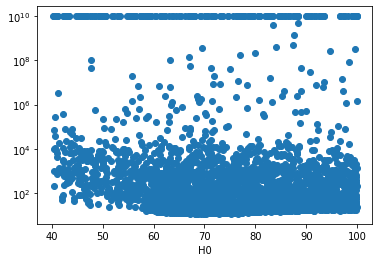

In [71]:
plt.scatter(chain_best["H0"], -chain_best["logl"])
plt.xlabel("H0")
plt.yscale("log")

Removed no burn in


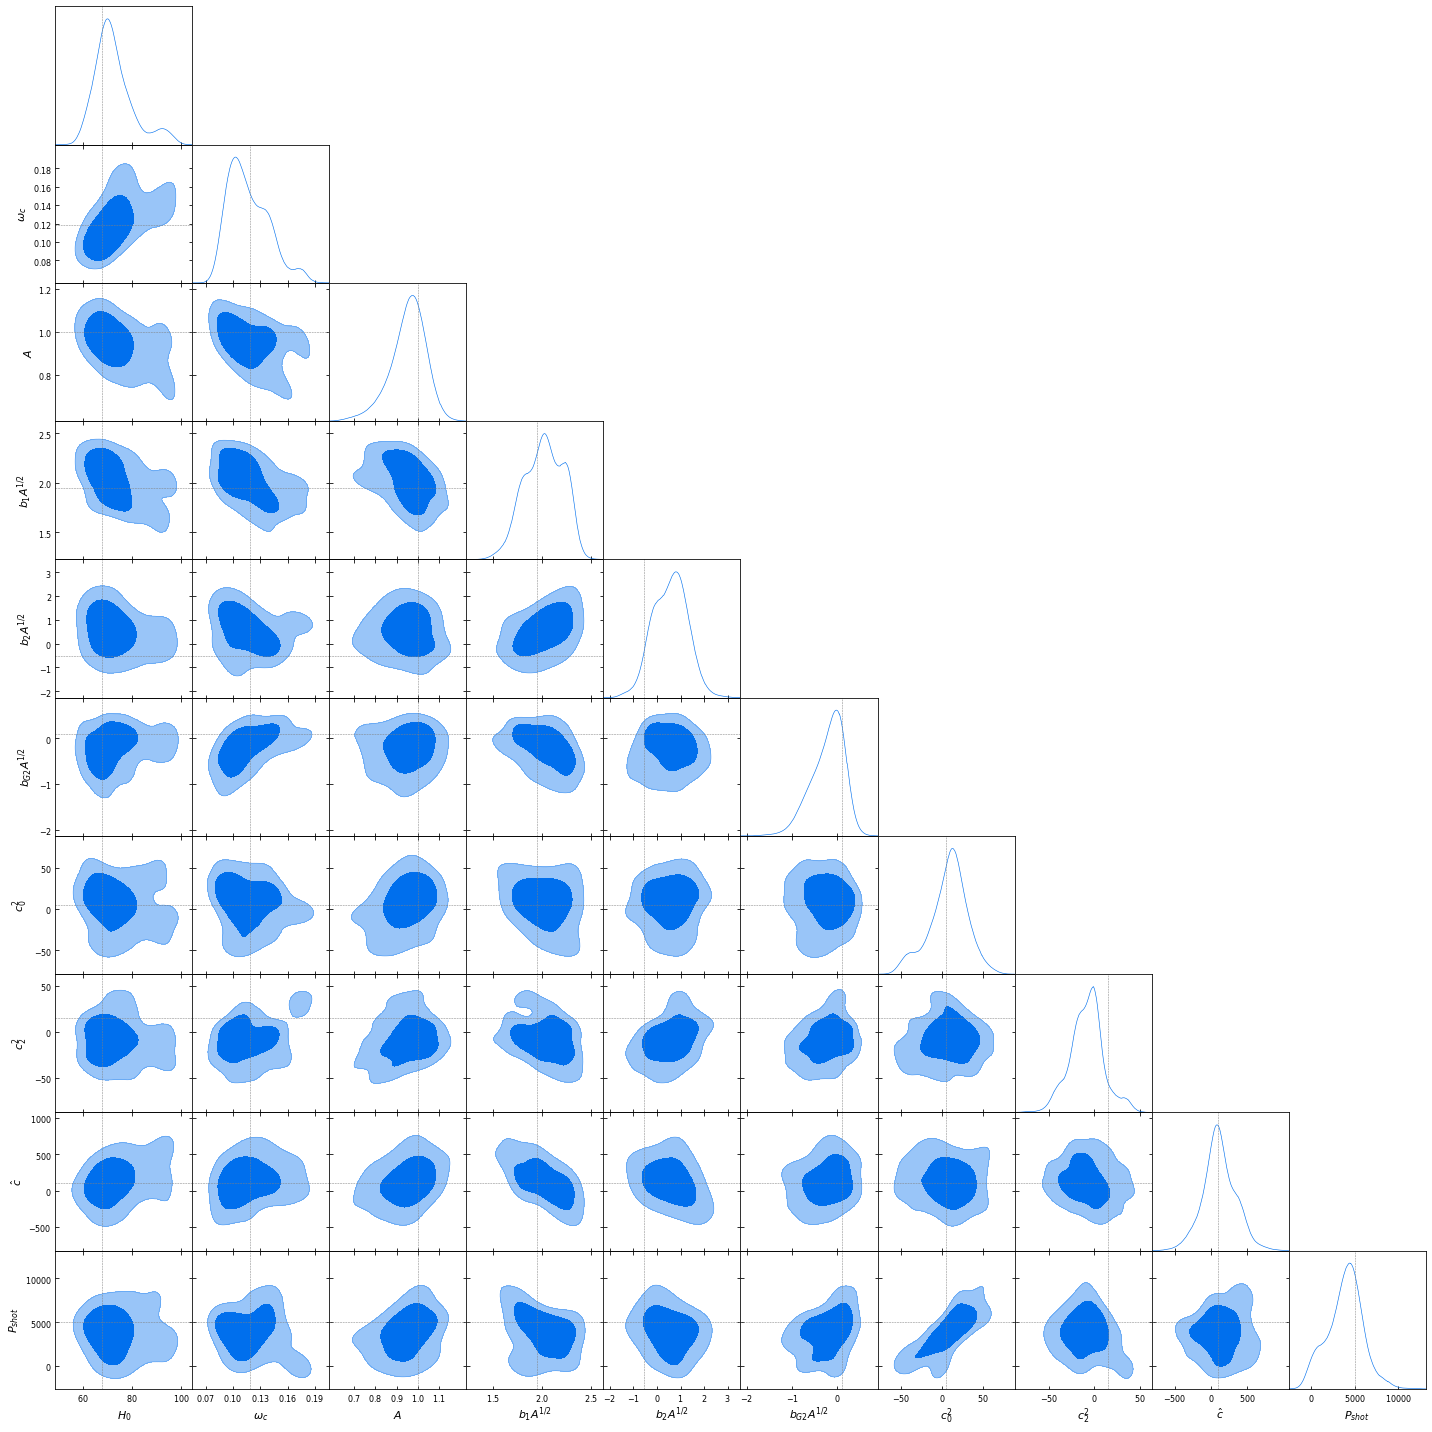

In [18]:
labels =  ["H_0", "\omega_c", "A", "b_1A^{1/2}", 'b_2A^{1/2}', "b_{G2}A^{1/2}", "c_0^2", "c_2^2", "\hat{c}", "P_{shot}"]
#labels =  ["H_0", "\omega_c"]#, "P_{shot}"]
cosmo_truth = [67.77, 0.11827,1,1.9485, -0.5387, 0.1, 5., 15., 100, 5e3]
#cosmo_truth = [67.77, 0.11827]#, 5e3]

#plot_cosmo_contours([chain_fid, chain_best], labels, cosmo_truth, ["Fixed Covariance (fiducial cosmology)", "Fixed Covariance (best-fit cosmology)"],10, True)
plot_cosmo_contours([chain_fid], labels, cosmo_truth, ["Fixed Covariance (fiducial cosmology)"],10, True)

Removed no burn in


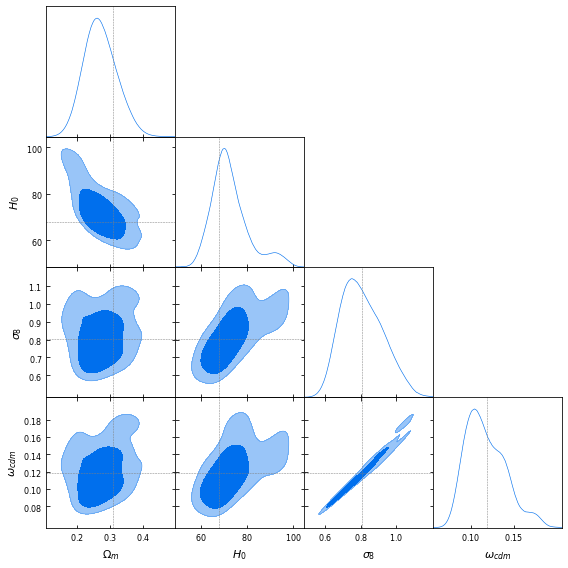

In [13]:
plot_derived_contours([chain_fid], ["Fixed Covariance (fiducial cosmology)"], True)
#plot_derived_contours([chain_fid, chain_best], ["Fixed Covariance (fiducial cosmology)", "Fixed Covariance (best-fit cosmology)"], True)

In [22]:
# Compare mean values with that of Wadekar et al (2020)
for name in chain_fid.dtype.names:
    # interval = st.norm.interval(alpha=0.68, loc=np.mean(chain[name]), scale=st.sem(chain[name]))
    # print(interval)
    if name != "weight" and name != "logl":
        mean = stats_fid[name+"_mean"]
        mean_2 = stats_best[name+"_mean"]
        #mean_2 = np.average((chain_fid[name]), weights=chain_fid["weight"])
        print(name)
        print("fiducial: {:0.4f} + {:0.4f} - {:0.4f} ({:0.4f})".format(stats_fid[name+"_mean"], mean - stats_fid[name+"_errlo"], stats_fid[name+"_errup"] - mean, stats_fid[name+"_stdev"]))
        print("updated:  {:0.4f} + {:0.4f} - {:0.4f} ({:0.4f})".format(stats_best[name+"_mean"], mean_2 - stats_best[name+"_errlo"], stats_best[name+"_errup"] - mean_2, stats_best[name+"_stdev"]))

H0
fiducial: 70.8476 + 5.9106 - 5.0003 (6.3261)
updated:  71.4000 + 5.1836 - 4.5914 (6.0215)
omch2
fiducial: 0.1120 + 0.0147 - 0.0142 (0.0155)
updated:  0.1153 + 0.0153 - 0.0163 (0.0162)
A
fiducial: 0.7573 + 0.0889 - 0.0873 (0.0948)
updated:  0.7160 + 0.0937 - 0.0943 (0.0938)
b1
fiducial: 2.8213 + 0.2298 - 0.2228 (0.2322)
updated:  2.9223 + 0.2160 - 0.2099 (0.2264)
b2
fiducial: -0.2566 + 0.9326 - 0.9594 (0.9610)
updated:  0.0434 + 0.8901 - 0.8928 (0.8494)
bG2
fiducial: -0.0442 + 0.7071 - 0.7011 (0.6666)
updated:  0.3067 + 0.6362 - 0.5960 (0.6098)
cs0
fiducial: 12.0884 + 24.6853 - 23.9548 (26.0740)
updated:  3.4233 + 29.6589 - 25.3655 (25.0910)
cs2
fiducial: 4.5396 + 23.5990 - 23.1982 (23.7613)
updated:  -1.2514 + 26.1512 - 26.9542 (26.2080)
cbar
fiducial: 381.8369 + 203.0332 - 204.8777 (207.1863)
updated:  327.0865 + 152.2400 - 146.8683 (161.6462)
Pshot
fiducial: 984.4084 + 1098.3636 - 1085.4467 (1109.4370)
updated:  862.8109 + 996.2532 - 1171.5305 (1189.8299)
Omega_0
fiducial: 0.2722 

In [33]:
# check how much the mean / error bars have shifted after switching input cosmologies
for name in chain_fid.dtype.names:
    
    if name != "weight" and name != "logl":
        shift = abs(stats_fid[name+"_mean"] - stats_best[name+"_mean"])
        shift_relative = shift / stats_fid[name+"_stdev"]
        sigma_shift = 100.*(stats_fid[name+"_stdev"] - stats_best[name+"_stdev"]) / stats_fid[name+"_stdev"]
        print(name)
        print("best-fit shift = {:0.3f}\t ({:0.2f} sigma)".format(shift, shift_relative))
        print("standard deviation shift = {:0.2f}%".format(sigma_shift))

## Old Metropolic-Hastings Code

In [ ]:
# load in the mcmc chain from file
N    = 100000
NDIM = 11
N_sub = 70000
file1 = np.load(data_dir+"mcmc_chains_Fixed.npz")
file2 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_Gaussian_Varied.npz")
file3 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_Cholesky_Varied.npz")
file4 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_SSC_Varied.npz")
file5 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_G_emulate_Varied.npz")
file6 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_Fixed_Far.npz")

chain_fixed = file1["chain"]
chain_fixed_far = file5["chain"]
chain_varied_G = file2["chain"]
chain_varied_G_emulated = file5["chain"]
chain_varied_C = file3["chain"]
chain_varied_SSC = file4["chain"]

#chain_fixed[:,3] = np.exp(chain_fixed[:,3]) / 1e10
chain_fixed_far[:,3] = np.exp(chain_fixed_far[:,3]) / 1e10
chain_varied_G[:,3] = np.exp(chain_varied_G[:,3]) / 1e10
chain_varied_G_emulated[:,3] = np.exp(chain_varied_G_emulated[:,3]) / 1e10
chain_varied_C[:,3] = np.exp(chain_varied_C[:,3]) / 1e10
chain_varied_SSC[:,3] = np.exp(chain_varied_SSC[:,3]) / 1e10

rate_T0 = file1["rate"]
rate_varied_G = file2["rate"]
rate_varied_C = file3["rate"]
rate_varied_SSC = file4["rate"]
lkl_T0 = file1["lkl"]
lkl_varied_G = file2["lkl"]
lkl_varied_C = file3["lkl"]
lkl_varied_SSC = file4["lkl"]

In [ ]:
fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM+1))
for i in range(NDIM):
    ax[i].plot(chain_fixed[:N_sub,i].T, 'k-', lw=0.3)
plt.show()  

In [26]:
# fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
# for i in range(NDIM):
#     ax[i].plot(chain_varied_G[:N_sub,i].T, 'k-', lw=0.3)
# plt.show()  

In [27]:
# fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
# for i in range(NDIM):
#     ax[i].plot(chain_varied_C[:N_sub,i].T, 'k-', lw=0.3)
# plt.show()  

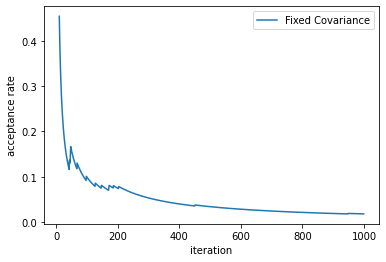

In [28]:
plt.plot(range(N)[10:N_sub], rate_T0[10:N_sub], label="Fixed Covariance")
#plt.plot(range(N)[10:N_sub], rate_varied_G[10:N_sub], label="Cosmo Dependent (Gaussian)")
#plt.plot(range(N)[10:N_sub], rate_varied_SSC[10:N_sub], label="Cosmo Dependent (Gaussian + SSC)")
#plt.plot(range(N)[10:N_sub], rate_varied_C[10:N_sub], label="Cosmo Dependent (Cholesky)")
plt.xlabel("iteration")
plt.ylabel("acceptance rate")
plt.legend()

950
[ 8.01339270e+01  6.02097967e-02  5.78783497e-02  1.12499559e+00
  9.97748712e-01  2.78217116e+00 -4.97658935e+00  7.10325142e+00
 -1.01587059e+01 -1.66330943e+02  5.63915219e+03]


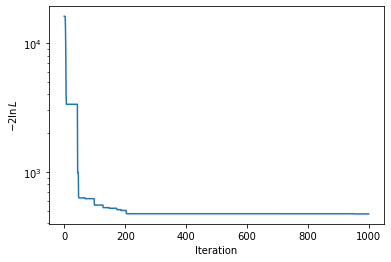

In [30]:
print(np.argmin(-2*lkl_T0[:N_sub]))
print(chain_fixed[:N_sub][-1])
plt.plot(range(N)[:N_sub], -2*lkl_T0[:N_sub])
plt.xlabel("Iteration")
plt.ylabel(r"$-2 \ln{L}$")
plt.yscale("log")

In [31]:
C_theta = np.cov(chain_fixed[0:N_sub], rowvar=False)
for i in range(C_theta.shape[0]):
    print("[",end =" ")
    for j in range(C_theta.shape[1]):
        print(str(C_theta[i,j]) + ",",end =" ")
    print("],")
    
for i in range(11):
    print(np.sqrt(C_theta[i,i]))

[ 0.1697034955221653, 0.0018756485455925004, -0.00012755042936932873, -0.010332333097359852, -0.0033011799151297146, 0.006200354536014686, -0.6436928031008571, -0.08722384596619201, -0.4350313866824416, -5.051284489525018, 256.2780292321567, ],
[ 0.0018756485455925004, 2.799370316852879e-05, -1.8453784982465928e-06, -0.00012758186346366332, -1.8352429736795777e-05, 0.0006312252042537553, -0.00801201765737572, -0.0004823754046332929, 0.0020136988499557746, -0.07129976129068936, 2.9971432614722766, ],
[ -0.00012755042936932873, -1.8453784982465928e-06, 1.280591606786456e-07, 1.3229372538141804e-05, 1.5038287395589148e-06, -3.961782848568164e-05, 0.0005532574588257828, 6.938278190532095e-05, 3.396951038779364e-05, 0.0041763784899615745, -0.17264736168221614, ],
[ -0.010332333097359852, -0.00012758186346366332, 1.3229372538141804e-05, 0.005992943270853318, 0.0002207541695949502, -0.00964197579582706, 0.03595480215171107, 0.036787840412673654, 0.052665129782016276, -0.4277753279325201, 30.2

In [18]:
N_BURN_IN = 4200

samples_fixed = chain_fixed[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_fixed_far = chain_fixed_far[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_G = chain_varied_G[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_G_emulated = chain_varied_G_emulated[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_SSC = chain_varied_SSC[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_C = chain_varied_C[N_BURN_IN:N_sub, :].reshape((-1,NDIM))

## Figure of Merit Code  
The Figure of Merit is defined in https://www.nsf.gov/mps/ast/aaac/dark_energy_task_force/report/detf_final_report.pdf as  
$$ FoM = \sqrt{det(C_{\theta_i, \theta_j}^{-1})} $$  
Where C is the covariance matrix of 2 parameters $\theta_i$ and $\theta_j$ in a given MCMC chain (late time). Normally this stat is used for $w_0$ and $w_a$, but it can technically be used for any pair of parameters you are scanning over.

In [10]:
def FoM(param_1, param_2):
    chain_1 = np.vstack((chain_fixed[10000:N_sub, param_1], chain_fixed[10000:N_sub, param_2])).T
    chain_gaussian = np.vstack((chain_varied_C[10000:N_sub, param_1], chain_varied_C[10000:N_sub, param_2])).T

    num_bins = 15
    FoM_1, FoM_2 = np.zeros(num_bins), np.zeros(num_bins)
    chain_len_1, chain_len_2 = chain_1.shape[0], chain_gaussian.shape[0]
    for b in range(num_bins):
        subchain_1 = chain_1[b*int(chain_len_1 / num_bins):(b+1)*int(chain_len_1 / num_bins), :]
        subchain_gaussian = chain_gaussian[b*int(chain_len_2 / num_bins):(b+1)*int(chain_len_2 / num_bins), :]

        # calculate the covariance matrix of this subchain
        cov_1 = np.cov(subchain_1, rowvar=False)
        cov_2 = np.cov(subchain_gaussian, rowvar=False)
        FoM_1[b] = np.sqrt(np.linalg.det(np.linalg.inv(cov_1)))
        FoM_2[b] = np.sqrt(np.linalg.det(np.linalg.inv(cov_2)))

    # Calculate the FoM for the last 30% of the chain
    cov_1 = np.cov(chain_1[int(0.7*chain_len_1):,:], rowvar=False)
    cov_2 = np.cov(chain_gaussian[int(0.7*chain_len_2):,:], rowvar=False)
    FoM_30 = [np.sqrt(np.linalg.det(np.linalg.inv(cov_1))), np.sqrt(np.linalg.det(np.linalg.inv(cov_2)))]
    
    return FoM_1, FoM_2, FoM_30

/tmp/ipykernel_815237/4256885081.py:25: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Fixed Covariance", "Cosmo Dependent Covariance"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.03))


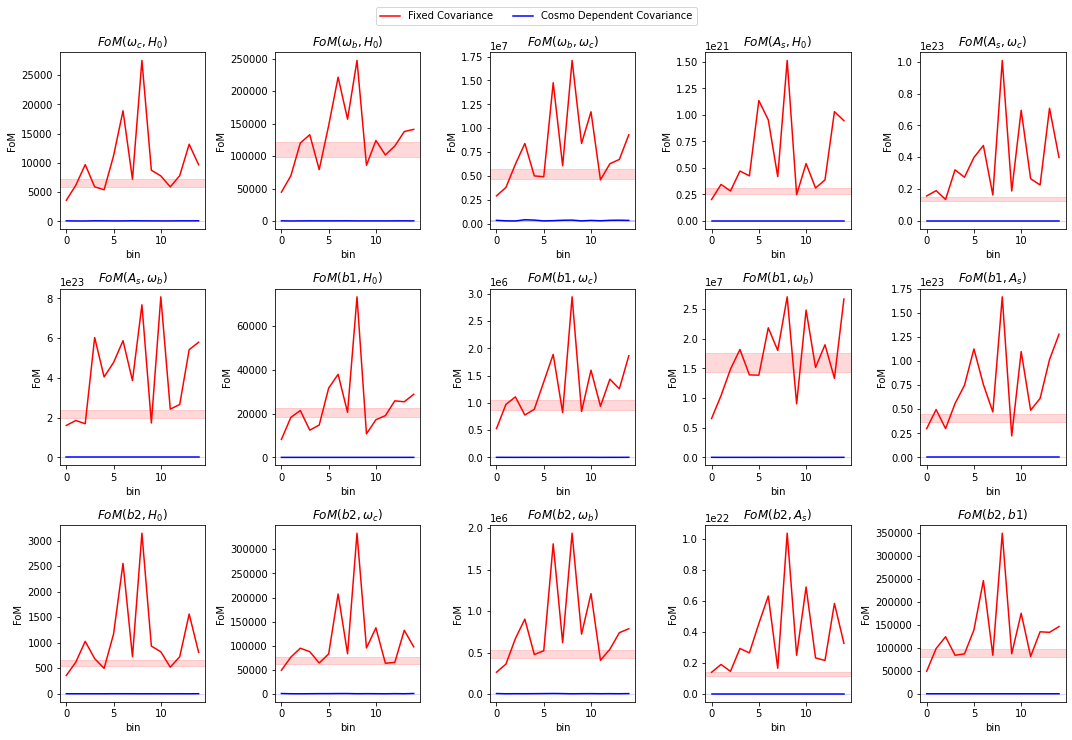

In [11]:
fig, axs = plt.subplots(3, 5, figsize=(15,10))
labels =  ["H_0", '\omega_c', '\omega_b', 'A_s', 'b1', 'b2']
num_bins = 15
idx = 0
ax_list = axs.ravel()
for i in range(6):
    for j in range(6):
        if j >= i:
            continue
        FoM_1, FoM_2, FoM_30 = FoM(i, j)
        ax_list[idx].set_title(r"$FoM(" + labels[i] + ", " + labels[j] + ")$")
        l1 = ax_list[idx].plot(range(num_bins), FoM_1, c="red")
        l2 = ax_list[idx].plot(range(num_bins), FoM_2, c="blue")

        h1 = ax_list[idx].axhspan(FoM_30[0]*0.9, FoM_30[0]*1.1, color="red", alpha=0.15)
        h2 = ax_list[idx].axhspan(FoM_30[1]*0.9, FoM_30[1]*1.1, color="blue", alpha=0.15)
        
        #ax[0].set_yscale("log")
        ax_list[idx].set_xlabel("bin")
        ax_list[idx].set_xlabel("bin")
        ax_list[idx].set_ylabel("FoM")

        idx+= 1
        
fig.legend([l1, l2], labels=["Fixed Covariance", "Cosmo Dependent Covariance"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.03))
plt.tight_layout()

In [ ]:
plot_cosmo_contours([samples_fixed, samples_fixed_far], ["Fixed Covariance (fiducial cosmology)", "Fixed Covariance (exotic cosmology)"],6)

In [ ]:
plot_cosmo_contours([samples_fixed, samples_varied_C], ["Fixed Covariance (Gaussian + SSC + T0)", "Cosmo Dependent (Gaussian + SSC + T0)"],6)

In [ ]:
plot_cosmo_contours([samples_varied_G, samples_varied_SSC, samples_varied_C], ["Gaussian only", "Gaussian + SSC", "Gaussian + SSC + T0"],6)

In [ ]:
plot_cosmo_contours([samples_varied_G, samples_varied_G_emulated], ["Cosmo Dependent (Gaussian brute force)", "Cosmo Dependent (Gaussian emulated)"],6)

0.9999994246148275
1.5
2.4999994246148276
3.499998849229655
4.499998273844483
5.49999769845931


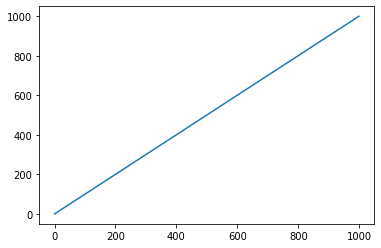

In [42]:
t_correlate = np.zeros(1000)
X0 = samples_fixed[0,:]
corr = np.corrcoef(samples_fixed[:1000,:], rowvar=True)
print(corr[0,5])
for K in range(1000):
    t = 0.5
    for k in range(K):
        Xk = samples_fixed[k,:]
        t += corr[0, k]
        if K == 5: print(t)
    t_correlate[K] = t

plt.plot(range(1000), t_correlate)

## Multinest Code

  analysing data from /home/joeadamo/Research/CovNet/chains/MontePython/montepython-data/multinest/NS/multinest-.txt


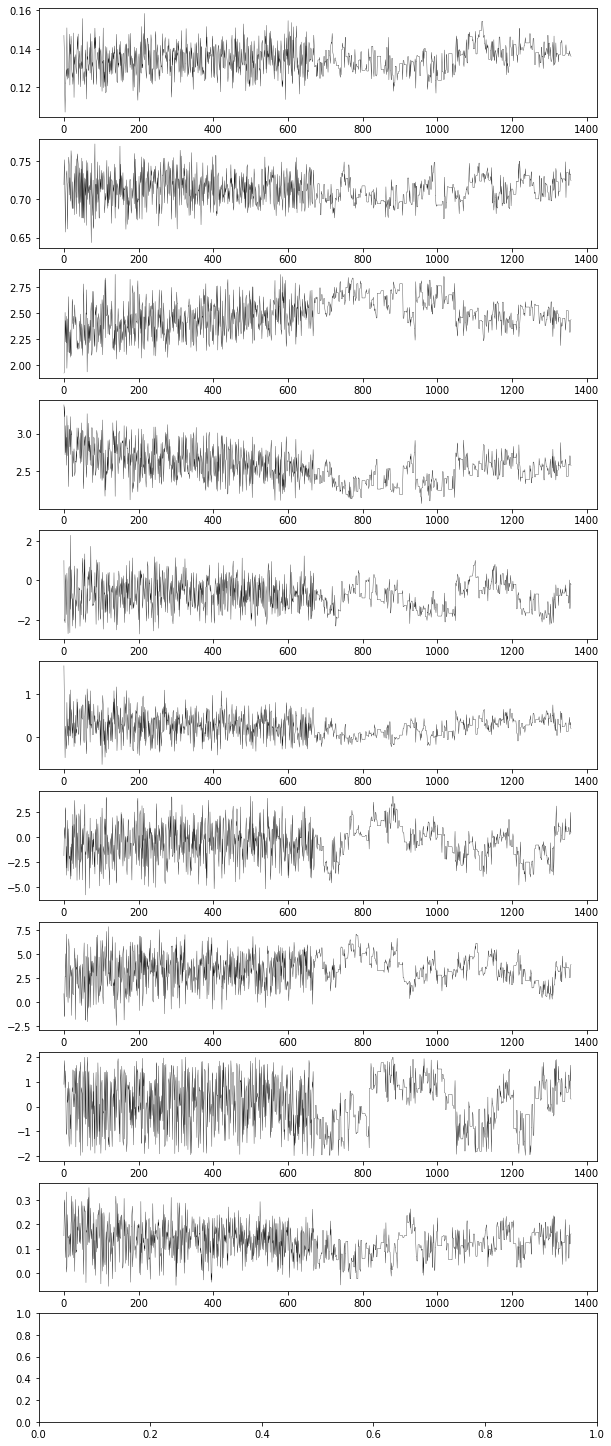

In [9]:
# lets analyse the results
import pymultinest
NDIM=10
multinest_dir = "/home/joeadamo/Research/CovNet/chains/MontePython/montepython-data/multinest/NS/multinest-"

a_T0 = pymultinest.Analyzer(n_params = 10, outputfiles_basename=multinest_dir)
#a_no_T0 = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=chains_dir+prefix[1])
#s = a.get_stats()

# This takes the end of the chain calculated by multinest
chain_Mult_T0 = a_T0.get_equal_weighted_posterior()
#chain_Mult_no_T0 = a_no_T0.get_equal_weighted_posterior()

#chain_Mult_T0[:,3] = np.exp(chain_Mult_T0[:,3]) / 1e10
#chain_Mult_no_T0[:,3] = np.exp(chain_Mult_no_T0[:,3]) / 1e10
fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
for i in range(NDIM):
    ax[i].plot(chain_Mult_T0[:,i], 'k-', lw=0.3)
#fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
#for i in range(7):
#    ax[i].plot(chain_Mult_no_T0[:,i], 'k-', lw=0.3)
plt.show()

In [10]:
N_BURN_IN = 10
Omega_b = 0.048206; h = cosmo_fid[0] / 100.
Omega_m = 0.307115

#samples_fixed = chain_fixed[N_BURN_IN:, :].reshape((-1,NDIM))
# look into what the consensus is for using the T0 term <- can look at this in the simulation case as well
samples_1 = chain_Mult_T0[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
#samples_2 = chain_Mult_no_T0[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
plot_cosmo_contours([samples_1], [ "Fixed Covariance"], 10)
#plot_cosmo_contours(samples_2, samples_2, [ "No T0 term", "No T0 term"], 6

TypeError: plot_cosmo_contours() missing 1 required positional argument: 'num_plots'

100%|███████████████████████████████████████| 2159/2159 [11:32<00:00,  3.12it/s]


Removed no burn in


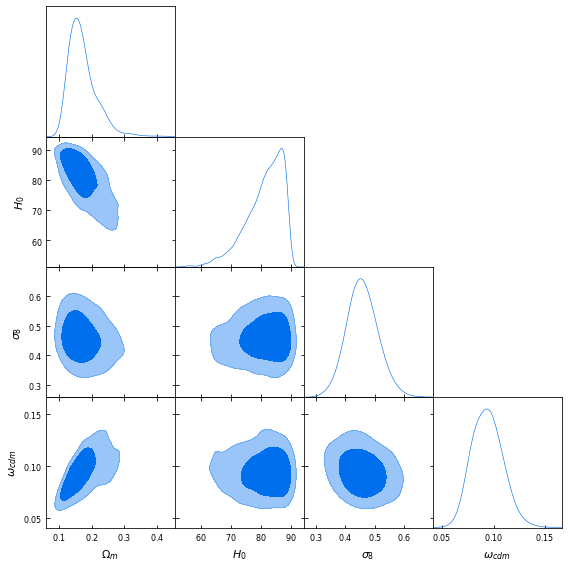

In [34]:
plot_derived_contours([samples_1], [ "Fixed Covariance"], True)

In [ ]:
# print("\tFull Covariance\t\t\tNo T0")

# # print(str(parameters[0])+":\t {:0.2f} +- {:0.2f}\t\t\t {:0.2f} +- {:0.2f}".format(np.mean(chain_fixed[:,0]), np.std(chain_fixed[:,0]), np.mean(chain_no_T0[:,0]), np.std(chain_no_T0[:,0])))
# # print(str(parameters[1])+":\t {:0.4f} +- {:0.4f}\t\t {:0.4f} +- {:0.4f}".format(np.mean(chain_fixed[:,1]), np.std(chain_fixed[:,1]), np.mean(chain_no_T0[:,1]), np.std(chain_no_T0[:,1])))
# # print(str(parameters[2])+":\t {:0.5f} +- {:0.5f}\t\t {:0.5f} +- {:0.5f}".format(np.mean(chain_fixed[:,2]), np.std(chain_fixed[:,2]), np.mean(chain_no_T0[:,2]), np.std(chain_no_T0[:,2])))
# # print(str(parameters[3])+":\t {:0.2e} +- {:0.2e}\t\t {:0.2e} +- {:0.2e}".format(np.mean(chain_fixed[:,3]), np.std(chain_fixed[:,3]), np.mean(chain_no_T0[:,3]), np.std(chain_no_T0[:,3])))
# # print(str(parameters[4])+":\t {:0.3f} +- {:0.2f}\t\t\t {:0.3f} +- {:0.3f}".format(np.mean(chain_fixed[:,4]), np.std(chain_fixed[:,4]), np.mean(chain_no_T0[:,4]), np.std(chain_no_T0[:,4])))
# # print(str(parameters[5])+":\t {:0.3f} +- {:0.2f}\t\t\t {:0.3f} +- {:0.3f}".format(np.mean(chain_fixed[:,5]), np.std(chain_fixed[:,5]), np.mean(chain_no_T0[:,5]), np.std(chain_no_T0[:,5])))

# for i in range(6):
#     print("shift: {:0.3f} sigma".format((abs(np.mean(chain_fixed[:,i]) - np.mean(chain_no_T0[:,i])) / np.std(chain_fixed[:,i]))))

took 1.491 s
0.8295181125359163


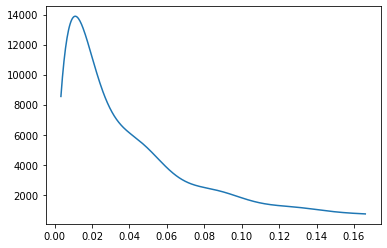

In [20]:
k_mpc = np.linspace(0.005,0.245,400) * 0.6777 # in 1/Mpc
cosmo = Class()
z_pk = 0.61
cosmo.set({'A_s':2.207e-9,
           'n_s':0.9645,
           'tau_reio':0.052,
           'omega_b':0.02215,
           'omega_cdm':0.1190,
           'h':0.6777,
           'YHe':0.2425,
           'N_ur':2.0328,
           'N_ncdm':1,
           'm_ncdm':0.06,
           'T_ncdm': 0.71611,
           'z_pk':z_pk
          })  
#Set additional CLASS-PT settings
cosmo.set({'output':'mPk',
           'non linear':'None',
           #'IR resummation':'No',
           #'Bias tracers':'Yes',
           'FFTLog mode':'FAST',
           'cb':'Yes', # use CDM+baryon spectra
           #'RSD':'No',
           #'AP':'No', # Alcock-Paczynski effect
           'Omfid':'0.31', # fiducial Omega_m
           #'PNG':'No' # single-field inflation PNG
         })
t1 = time.time()
cosmo.compute()
print("took {:0.3f} s".format(time.time() - t1))

pk_lin = np.asarray([cosmo.pk_lin(kk,0.61) for kk in k_mpc]) # in Mpc^3
pk_lin *= 0.6777**3
sigma8 = cosmo.sigma8()
print(sigma8)
plt.plot(k_mpc, pk_lin)